In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

training_data = np.load('/content/gdrive/My Drive/training_n_data.npy')[:2000]
training_std = np.load('/content/gdrive/My Drive/training_std.npy')[:2000]

testing_data = np.load('/content/gdrive/My Drive/testing_n_data.npy')[:2000]
testing_std = np.load('/content/gdrive/My Drive/testing_std.npy')[:2000]

# Reshape to 2D Array
training_data = training_data.reshape(training_data.shape[0], 3, -1)
testing_data = testing_data.reshape(testing_data.shape[0], 3, -1)

# Convert to PyTorch tensors
training_data_tensor = torch.tensor(training_data, dtype=torch.float32).to(device)
training_std_tensor = torch.tensor(training_std, dtype=torch.float32).to(device)
testing_data_tensor = torch.tensor(testing_data, dtype=torch.float32).to(device)
testing_std_tensor = torch.tensor(testing_std, dtype=torch.float32).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(training_data_tensor, training_std_tensor)
test_dataset = TensorDataset(testing_data_tensor, testing_std_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

cuda


In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 82, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(82 * (input_size - 3), 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model = CNN(40)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def run_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=10):
    for i in range(epochs):
        #(f"Starting epoch {i + 1} of {epochs}")
        train_loss = 0.0
        test_loss = 0.0

        model.train()
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            y_pred = model(X_train)
            target = y_train.view(-1, 1)
            target = target.expand_as(y_pred)
            loss = criterion(y_pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)
        #print(f"Average training loss for epoch {i + 1}: {average_train_loss}")

        model.eval()
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                y_val = model(X_test)
                target = y_test.view(-1, 1)
                target = target.expand_as(y_val)
                loss = criterion(y_val, target)
                test_loss += loss.item()

        average_test_loss = test_loss / len(test_loader)
        if i % (epochs//2) == 0:
          print(f"Epoch {i}/{epochs} | Testing Loss: {average_test_loss} | Training Loss: {average_train_loss} ")

    return average_train_loss, average_test_loss

In [ ]:
def removal_from_sides(model, train_loader, test_loader, criterion, optimizer, device, epochs=15):
    results = []  # list to hold the results

    for i in range(train_loader.dataset.tensors[0].size(2), 0, -1):
        if i <= 3:
          break
        else:
          for side in ['left', 'right']:
              print(f"Training with {i} features, removing from {side}")

              if side == 'left':
                  train_data = train_loader.dataset.tensors[0][:, :, :i].clone()
                  test_data = test_loader.dataset.tensors[0][:, :, :i].clone()
              else:  # 'right'
                  train_data = train_loader.dataset.tensors[0][:, :, -i:].clone()
                  test_data = test_loader.dataset.tensors[0][:, :, -i:].clone()

              input_size = train_data.size(2)  # Update the input size

              model = CNN(input_size)  # Update the model initialization
              model.to(device)
              optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

              train_loader_ablated = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(train_data, train_loader.dataset.tensors[1]),
                  batch_size=train_loader.batch_size,
                  shuffle=True
              )

              test_loader_ablated = torch.utils.data.DataLoader(
                  torch.utils.data.TensorDataset(test_data, test_loader.dataset.tensors[1]),
                  batch_size=test_loader.batch_size,
              )

              average_train_loss, average_test_loss = run_model(
                  model, train_loader_ablated, test_loader_ablated, criterion, optimizer, device, epochs
              )

              results.append((i, side, average_train_loss, average_test_loss))

    return results


In [ ]:
results = removal_from_sides(model, train_loader, test_loader, criterion, optimizer, device, epochs=100)

In [ ]:
def plot_results(results):
    num_features = [r[0] for r in results]
    sides = [r[1] for r in results]
    MAE = [r[3] for r in results]

    fig, ax = plt.subplots(figsize=(10,4))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax.scatter(num_features[::2], MAE[::2], label='From Left')
    ax.scatter(num_features[1::2], MAE[1::2], label='From Right')
    ax.set_xlabel('Number of Features Per Channel')
    ax.set_ylabel('MAE')
    ax.legend(fontsize=15)
    ax.set_ylim(0, 0.255)
    ax.invert_xaxis()
    plt.show()


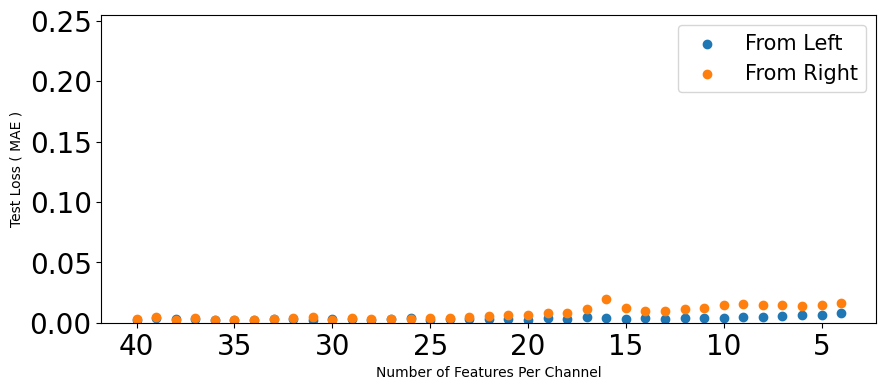

In [ ]:
plot_results(results)